# TBD - etap 2b

### Michał Kopyt, Rafał Kulus, Adrian Prorok

##  Inicjalizacja sesji sparkowej, załadowanie bibliotek pyspark, SynapseML oraz pysparkling i połączenie do klastra H2O:

In [1]:
pip install h2o_pysparkling_3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 MB 3.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 14.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for h2o_pysparkling_3.2: filename=h2o_pysparkling_3.2-3.38.0.4.post1-py2.py3-none-any.whl size=162427908 sha256=e5c113acd8802d72b1d79b9d57599950319df8e28140439fada274a7fd5caf88
  Stored in directory: /home/jovyan/.cache/pip/wheels/8d/b1/1a/48d776d100aa559b012748271998372ccae02a056f1362d95c
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=4e00ad4dc568ceeee29acc674116a3f0ba63db00341230a08b8d8bb6ba8286e7
  Stored in directory: /home/jovyan/.cache/pip/wheels/22/73/06/557dc4f4ef68179b9d763930d6eec26b88ed7c389b19588a1c
Successfully built h2o_pysparkling_3.2 future
Note: you may need to restart the kernel to use updated packages.


In [2]:
seed = 20031999

In [3]:
import pyspark
from pyspark.conf import SparkConf

spark = pyspark.sql.SparkSession.builder.appName("tbd") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5") \
    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
    .getOrCreate()

from pysparkling import *
import h2o
hc = H2OContext.getOrCreate()

Connecting to H2O server at http://7f7568e50b58:54323 ... successful.


H2O_cluster_uptime:,19 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,3 days
H2O_cluster_name:,sparkling-water-jovyan_local-1673275798979
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,892 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.38.0.4-1-3.2
 * H2O name: sparkling-water-jovyan_local-1673275798979
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.17.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://7f7568e50b58:54323 (CMD + click in Mac OSX)

    


## Importy

In [4]:
from pyspark.sql.functions import col, to_date, month, to_timestamp, hour, regexp_replace
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

from timeit import default_timer as timer
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_auc_score, accuracy_score

from pyspark.ml.classification import LogisticRegression, GBTClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from pysparkling.ml import H2OGLM, H2OXGBoostClassifier, H2OGridSearch
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from synapse.ml.lightgbm import LightGBMClassifier
from synapse.ml.train import TrainClassifier, ComputeModelStatistics
from synapse.ml.automl import FindBestModel

## Ładowanie danych

In [5]:
csv_path_1e4 = 'file:////home/jovyan/work/tbd-notebooks/data/ds1-1e4.csv'
csv_path_1e5 = 'file:////home/jovyan/work/tbd-notebooks/data/ds1-1e5.csv'
csv_path_1e6 = 'file:////home/jovyan/work/tbd-notebooks/data/ds1-1e6.csv'

##  Przygotowanie funkcji do ładowania i przygotowania danych na podstawie wybranego pliku:

### Dodane atrybuty

- Month - zastępuje Date z oryginalnych danych, one hot encoding
- Hour - zastępuje Time z oryginalnych danych, one hot encoding

### Zmodyfikowane atrybuty

- Light_Conditions - dla poprawnego działania implementacji z biblioteki SynapseML konieczne było usunięcie znaku ":" z wartości w tej kolumnie

### Usunięte atrybuty

- V1
- Accident_Index
- Location_Easting_OSGR
- Location_Northing_OSGR
- Accident_Severity
- Date - zastąpione atrybutem Month
- Time - zastąpione atrybutem Hour
- Local_Authority_(District)
- Local_Authority_(Highway)
- 1st_Road_Number
- 2nd_Road_Number
- LSOA_of_Accident_Location
- Year

### Ostatecznie wybrane atrybuty do uczenia i predykcji

- Longitude
- Latitude
- Police_Force
- Number_of_Vehicles
- Number_of_Casualties
- Speed_limit
- Day_of_Week (one hot encoding)
- 1st_Road_Class (one hot encoding)
- Road_Type (one hot encoding)
- Junction_Control (one hot encoding)
- 2nd_Road_Class (one hot encoding)
- Pedestrian_Crossing-Human_Control (one hot encoding)
- Pedestrian_Crossing-Physical_Facilities (one hot encoding)
- Light_Conditions (one hot encoding)
- Weather_Conditions (one hot encoding)
- Road_Surface_Conditions (one hot encoding)
- Special_Conditions_at_Site (one hot encoding)
- Carriageway_Hazards (one hot encoding)
- Urban_or_Rural_Area (one hot encoding)
- Did_Police_Officer_Attend_Scene_of_Accident (one hot encoding)
- Month (one hot encoding)
- Hour (one hot encoding)

### **W otrzymanym zbiorze danych znajduje się atrybut "Accident_Severity", który idealnie mapuje się na naszą zmienną objaśnianą. Samo jego użycie dało by nam najlepsze możliwe do uzyskania wyniki modeli, jednak z oczywistych przyczyn na potrzeby zadania zrezygnowaliśmy z niego.**

In [6]:
def get_features_df(csv_path):
    df = spark.read.csv(csv_path, inferSchema=True, header="true", nullValue='NA', nanValue='NA',emptyValue='NA')
    df = df.filter('Longitude is not NULL and Latitude is not NULL')
    df = df.withColumn('label', df.label.cast('integer'))
    
    df = df.withColumn('Date', to_date(df.Date, 'dd/MM/yyyy'))
    df = df.withColumn('Month', month(df.Date))
    df = df.withColumn('Time', to_timestamp(df.Time, 'HH:mm'))
    df = df.withColumn('Hour', hour(df.Time))
    
    df = df.withColumn('Light_Conditions', regexp_replace('Light_Conditions', ':', ''))
    
    df = df.drop('V1', 'Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Accident_Severity', 'Date', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Number', '2nd_Road_Number', 'LSOA_of_Accident_Location', 'Year')
    
    columns_for_one_hot_encoding = ['Day_of_Week', '1st_Road_Class', 'Road_Type', 'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Month', 'Hour']
    other_columns = ['Longitude', 'Latitude', 'Police_Force', 'Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']

    stringindexer_stages = [StringIndexer(inputCol=c, outputCol='stringindexed_' + c).setHandleInvalid("keep") for c in columns_for_one_hot_encoding]
    onehotencoder_stages = [OneHotEncoder(inputCol='stringindexed_' + c, outputCol='onehot_' + c) for c in columns_for_one_hot_encoding]

    extracted_columns = ['onehot_' + c for c in columns_for_one_hot_encoding]
    vectorassembler_stage = VectorAssembler(inputCols=extracted_columns + other_columns, outputCol='features')
    
    pipeline_stages = stringindexer_stages + onehotencoder_stages + [vectorassembler_stage]
    
    return Pipeline(stages=pipeline_stages).fit(df).transform(df).select(['features', 'label'])

## Dodatkowe klasy i funkcje do eksperymentów

In [7]:
class ModelTestingResults:
  def __init__(self, training_time = 0, auc = 0, accuracy = 0, confusion_matrix = None):
    self.training_time = training_time
    self.auc = auc
    self.accuracy = accuracy
    self.confusion_matrix = confusion_matrix

class ModelTuningResults:
  def __init__(self, tuned_params = {}, auc = 0, accuracy = 0, confusion_matrix = None):
    self.tuned_params = tuned_params
    self.auc = auc
    self.accuracy = accuracy
    self.confusion_matrix = confusion_matrix

def get_confusion_matrix(predictions_df):
    return predictions_df.select('label', 'prediction').groupBy('label', 'prediction').count().sort(col('label'), col('prediction')).toPandas()

def get_confusion_matrix_sklearn(testing_df, sklearn_pred):
    Y_testing = testing_df.select('label').toPandas().to_numpy().ravel()
    predictions_df = pd.DataFrame(data={'prediction': sklearn_pred, 'label': Y_testing})
    return predictions_df.groupby(['label','prediction'])[['label','prediction']].size().reset_index(name='count').sort_values(by=['label', 'prediction']).reset_index(drop=True)

def print_model_testing_results(model_testing_results, label):
    if label:
        print(f'----- {label} -----')
    print(f'Czas trenowania: {round(model_testing_results.training_time, 3)}s')
    print(f'AUC: {round(model_testing_results.auc, 3)}')
    print(f'Accuracy: {round(model_testing_results.accuracy, 3)}')
    print('Macierz pomyłek:')
    print(model_testing_results.confusion_matrix)

    
def print_model_tuning_results(model_tuning_results, label):
    if label:
        print(f'----- {label} -----')
    if model_tuning_results.tuned_params:
        print('Zoptymalizowane parametry:')
        for param in model_tuning_results.tuned_params.keys():
            if type(model_tuning_results.tuned_params[param] == str):
                print(f'    {param}: {model_tuning_results.tuned_params[param]}')
            else:
                print(f'    {param}: {round(model_tuning_results.tuned_params[param], 3)}')
    print(f'AUC: {round(model_tuning_results.auc, 3)}')
    print(f'Accuracy: {round(model_tuning_results.accuracy, 3)}')
    print('Macierz pomyłek:')
    print(model_tuning_results.confusion_matrix)

# Przygotowanie funkcji do testowania modeli

W poniższej sekcji przygotowaliśmy funkcje służące do trenowania odpowiednich modeli, ich testowania oraz przygotowania w zwięzłej formie wyników badań dla poszczególnych podpunktów niniejszego sprawozdania.

## sparkML

In [8]:
sparkML_evaluator_auroc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")
sparkML_evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

def test_sparkML(base_model, training_df, testing_df):
    training_start_time = timer()
    model = base_model.fit(training_df)
    training_end_time = timer()
    
    prediction_df = model.transform(testing_df)
    
    return ModelTestingResults(
        training_time=training_end_time - training_start_time,
        auc=sparkML_evaluator_auroc.evaluate(prediction_df),
        accuracy=sparkML_evaluator_accuracy.evaluate(prediction_df),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

def test_sparkML_lr_basic_version(training_df, testing_df):
    sparkML_lr = LogisticRegression()
    return test_sparkML(sparkML_lr, training_df, testing_df)

def test_sparkML_gbt_basic_version(training_df, testing_df):
    sparkML_gbt = GBTClassifier()
    return test_sparkML(sparkML_gbt, training_df, testing_df)

def tune_and_test_sparkML_lr(training_df, testing_df):
    sparkML_lr = LogisticRegression()

    param_grid = ParamGridBuilder() \
        .addGrid(sparkML_lr.regParam,[0.0, 0.005, 0.01, 0.015, 0.02, 0.025]) \
        .addGrid(sparkML_lr.elasticNetParam, [0.0, 0.5, 0.55, 0.6, 0.65, 0.7]) \
        .build()
    cv = CrossValidator(estimator=sparkML_lr, estimatorParamMaps=param_grid, evaluator=sparkML_evaluator_auroc, numFolds=4)
    cv_model = cv.fit(training_df)
    best_model = cv_model.bestModel

    prediction_df = best_model.transform(testing_df)
    tuned_params = {
        'regParam': best_model.extractParamMap().get(sparkML_lr.regParam),
        'elasticNetParam': best_model.extractParamMap().get(sparkML_lr.elasticNetParam)
    }
    
    return ModelTuningResults(
        tuned_params=tuned_params,
        auc=sparkML_evaluator_auroc.evaluate(prediction_df),
        accuracy=sparkML_evaluator_accuracy.evaluate(prediction_df),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

def tune_and_test_sparkML_gbt(training_df, testing_df):
    sparkML_gbt = GBTClassifier()
    
    param_grid = ParamGridBuilder() \
        .addGrid(sparkML_gbt.maxDepth, [5, 10, 15]) \
        .addGrid(sparkML_gbt.maxBins, [16, 32, 64]) \
        .build()
    cv = CrossValidator(estimator=sparkML_gbt, estimatorParamMaps=param_grid, evaluator=sparkML_evaluator_auroc, numFolds=4)
    cv_model = cv.fit(training_df)
    best_model = cv_model.bestModel

    prediction_df = best_model.transform(testing_df)
    tuned_params = {
        'maxDepth': best_model.extractParamMap().get(sparkML_gbt.maxDepth),
        'maxBins': best_model.extractParamMap().get(sparkML_gbt.maxBins)
    }
    
    return ModelTuningResults(
        tuned_params=tuned_params,
        auc=sparkML_evaluator_auroc.evaluate(prediction_df),
        accuracy=sparkML_evaluator_accuracy.evaluate(prediction_df),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

## H2O-sparklinkg-water

In [9]:
def test_h2o(base_model, training_df, testing_df):
    training_start_time = timer()
    model = base_model.fit(training_df)
    training_end_time = timer()
    
    prediction_df = model.transform(testing_df)
    predicted_labels_for_testing_data = prediction_df.withColumn('prediction', prediction_df.prediction.cast('int')).select('prediction').toPandas().to_numpy().ravel()
    labels_for_testing_data = prediction_df.select('label').toPandas().to_numpy().ravel()
    probabilities_for_1 = prediction_df.withColumn('detailed_prediction', col('detailed_prediction').probabilities['1']).select('detailed_prediction').toPandas().to_numpy().ravel()
    
    return ModelTestingResults(
        training_time=training_end_time - training_start_time,
        auc=roc_auc_score(labels_for_testing_data, probabilities_for_1),
        accuracy=accuracy_score(labels_for_testing_data, predicted_labels_for_testing_data),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )
    
def test_h2o_lr_basic_version(training_df, testing_df):
    h2o_lr = H2OGLM(
        family="binomial",
        featuresCols=['features'],
        labelCol='label'
    )
    return test_h2o(h2o_lr, training_df, testing_df)

def test_h2o_gbt_basic_version(training_df, testing_df):
    h2o_gbt = H2OXGBoostClassifier(featuresCols=['features'], labelCol='label')
    return test_h2o(h2o_gbt, training_df, testing_df)

def tune_and_test_h2o_lr(training_df, testing_df):
    h2o_lr = H2OGLM(
        family="binomial",
        featuresCols=['features'],
        labelCol='label'
    )
    
    param_grid = {
        'alphaValue': [0.0, 0.5, 1.0] ,
        'lambdaValue': [0.0, 0.5, 1.0]
    }
    
    grid_search = H2OGridSearch(hyperParameters=param_grid, algo=h2o_lr, strategy="Cartesian")
    model = grid_search.fit(training_df)
    
    tuned_params = {
        'alphaValue': model.getAlphaValue()[0],
        'lambdaValue': model.getLambdaValue()[0]
    }
    
    prediction_df = model.transform(testing_df)
    predicted_labels_for_testing_data = prediction_df.withColumn('prediction', prediction_df.prediction.cast('int')).select('prediction').toPandas().to_numpy().ravel()
    labels_for_testing_data = prediction_df.select('label').toPandas().to_numpy().ravel()
    probabilities_for_1 = prediction_df.withColumn('detailed_prediction', col('detailed_prediction').probabilities['1']).select('detailed_prediction').toPandas().to_numpy().ravel()
    
    return ModelTuningResults(
        tuned_params=tuned_params,
        auc=roc_auc_score(labels_for_testing_data, probabilities_for_1),
        accuracy=accuracy_score(labels_for_testing_data, predicted_labels_for_testing_data),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

def tune_and_test_h2o_gbt(training_df, testing_df):
    h2o_gbt = H2OXGBoostClassifier(featuresCols=['features'], labelCol='label')
    
    param_grid = {
        'learnRate': [0.1, 0.2, 0.3, 0.4],
        'maxDepth': [6, 64],
    }
    
    grid_search = H2OGridSearch(hyperParameters=param_grid, algo=h2o_gbt, strategy="Cartesian")
    model = grid_search.fit(training_df)
    
    tuned_params = {
        'learnRate': model.getLearnRate(),
        'maxDepth': model.getMaxDepth()
    }
    
    prediction_df = model.transform(testing_df)
    predicted_labels_for_testing_data = prediction_df.withColumn('prediction', prediction_df.prediction.cast('int')).select('prediction').toPandas().to_numpy().ravel()
    labels_for_testing_data = prediction_df.select('label').toPandas().to_numpy().ravel()
    probabilities_for_1 = prediction_df.withColumn('detailed_prediction', col('detailed_prediction').probabilities['1']).select('detailed_prediction').toPandas().to_numpy().ravel()
    
    return ModelTuningResults(
        tuned_params=tuned_params,
        auc=roc_auc_score(labels_for_testing_data, probabilities_for_1),
        accuracy=accuracy_score(labels_for_testing_data, predicted_labels_for_testing_data),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

## scikit-learn (do implementacji nierozproszonej)

In [10]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def get_sklearn_X_and_y(data_df):
    features_num = data_df.first().features.size
    X = data_df.withColumn('x', vector_to_array('features')).select([col('x')[i] for i in range(features_num)]).toPandas()
    y = data_df.select('label').toPandas().to_numpy().ravel()
    return X, y

def test_sklearn_lr_basic_version(training_df, testing_df):
    sklearn_lr = SklearnLogisticRegression()
    
    training_start_time = timer()
    X, y = get_sklearn_X_and_y(training_df)
    model = sklearn_lr.fit(X, y)
    training_end_time = timer()
    
    X_testing, y_testing = get_sklearn_X_and_y(testing_df)
    prediction_df = model.predict(X_testing)
    
    return ModelTestingResults(
        training_time=training_end_time - training_start_time,
        auc=roc_auc_score(y_testing, model.predict_proba(X_testing)[::, 1]),
        accuracy=accuracy_score(y_testing, prediction_df),
        confusion_matrix=get_confusion_matrix_sklearn(testing_df, prediction_df)
    )

def tune_and_test_sklearn_lr(training_df, testing_df):
    sklearn_lr = SklearnLogisticRegression(max_iter=200, n_jobs=-1)
    # sklearn_lr = SklearnLogisticRegression()
    
    param_grid = {
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2'],
        'C': [0.1, 1.0, 10]
    }
    
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
    grid_search = GridSearchCV(estimator=sklearn_lr, param_grid=param_grid, cv=cv, scoring='roc_auc',error_score=0)
    X, y = get_sklearn_X_and_y(training_df)
    model = grid_search.fit(X, y)
        
    X_testing, y_testing = get_sklearn_X_and_y(testing_df)
    prediction_df = model.predict(X_testing)
    
    return ModelTuningResults(
        tuned_params=model.best_params_,
        auc=roc_auc_score(y_testing, model.predict_proba(X_testing)[::, 1]),
        accuracy=accuracy_score(y_testing, prediction_df),
        confusion_matrix=get_confusion_matrix_sklearn(testing_df, prediction_df)
    )

## SynapseML

In [11]:
def test_synapseML(base_model, training_df, testing_df):
    return test_sparkML(base_model, training_df, testing_df) # Ten sam kod

def test_synapseML_gbt_basic_version(training_df, testing_df):
    synapseML_gbt = LightGBMClassifier(objective="binary", featuresCol="features", labelCol="label")
    return test_synapseML(synapseML_gbt, training_df, testing_df)

def tune_and_test_synapseML_gbt(training_df, testing_df):
    learning_rates = [0.05, 0.1, 0.2, 0.4]
    synapseML_gbt_list = [
        LightGBMClassifier(objective="binary", featuresCol="features", labelCol="label", learningRate=lr) for lr in learning_rates
    ]
    synapseML_gbt_models = [
        TrainClassifier(model=gbt, labelCol='label').fit(training_df) for gbt in synapseML_gbt_list
    ]    
    model = FindBestModel(evaluationMetric="AUC", models=synapseML_gbt_models).fit(testing_df)
    prediction_df = model.transform(testing_df)
    
    return ModelTuningResults(
        auc=sparkML_evaluator_auroc.evaluate(prediction_df),
        accuracy=sparkML_evaluator_accuracy.evaluate(prediction_df),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

# **Regresja logistyczna - porównanie wyników klasyfikacji oraz czasu trenowania podstawowych wersji modeli dla różnych wielkości zbiorów danych**

Dla każdego otrzymanego zbioru danych, przeprowadziliśmy trenowanie podstawowych wersji (z domyślnymi parametrami) modeli typu regresja logistyczna. Ich implementacje zaczerpnęliśmy z trzech bibliotek: Spark, h2o-sparkling-water oraz scikit-learn (implementacja nierozproszona). Podczas trenowania mierzyliśmy jego czas, a następnie dla otrzymanych modeli sprawdziliśmy na zbiorze testowym wartości AUC, Accuracy oraz macierz pomyłek.

## Zbiór danych 1e4

In [12]:
training_df_1e4, testing_df_1e4 = get_features_df(csv_path_1e4).randomSplit([0.8, 0.2], seed=seed)

In [13]:
sparkML_lr_basic_1e4_results = test_sparkML_lr_basic_version(training_df_1e4, testing_df_1e4)

label_sparkML_lr_basic_1e4_results = 'Regresja logistyczna, sparkML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_lr_basic_1e4_results, label_sparkML_lr_basic_1e4_results)

----- Regresja logistyczna, sparkML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 7.959s
AUC: 0.646
Accuracy: 0.836
Macierz pomyłek:
   label  prediction  count
0      0         0.0      2
1      0         1.0    326
2      1         0.0      7
3      1         1.0   1698


In [14]:
h2o_lr_basic_1e4_results = test_h2o_lr_basic_version(training_df_1e4, testing_df_1e4)

label_h2o_lr_basic_1e4_results = 'Regresja logistyczna, H2O-sparkling-water, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_lr_basic_1e4_results, label_h2o_lr_basic_1e4_results)

----- Regresja logistyczna, H2O-sparkling-water, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 3.987s
AUC: 0.646
Accuracy: 0.837
Macierz pomyłek:
   label prediction  count
0      0          0      2
1      0          1    326
2      1          0      6
3      1          1   1699


In [15]:
sklearn_lr_basic_1e4_results = test_sklearn_lr_basic_version(training_df_1e4, testing_df_1e4)

label_sklearn_lr_basic_1e4_results = 'Regresja logistyczna, scikit-learn, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sklearn_lr_basic_1e4_results, label_sklearn_lr_basic_1e4_results)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


----- Regresja logistyczna, scikit-learn, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 3.289s
AUC: 0.646
Accuracy: 0.839
Macierz pomyłek:
   label  prediction  count
0      0           0      3
1      0           1    325
2      1           0      3
3      1           1   1702


## Zbiór danych 1e5

In [16]:
training_df_1e5, testing_df_1e5 = get_features_df(csv_path_1e5).randomSplit([0.8, 0.2], seed=seed)

In [17]:
sparkML_lr_basic_1e5_results = test_sparkML_lr_basic_version(training_df_1e5, testing_df_1e5)

label_sparkML_lr_basic_1e5_results = 'Regresja logistyczna, sparkML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_lr_basic_1e5_results, label_sparkML_lr_basic_1e5_results)

----- Regresja logistyczna, sparkML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 9.285s
AUC: 0.662
Accuracy: 0.849
Macierz pomyłek:
   label  prediction  count
0      0         0.0     11
1      0         1.0   2998
2      1         0.0     13
3      1         1.0  16870


In [18]:
h2o_lr_basic_1e5_results = test_h2o_lr_basic_version(training_df_1e5, testing_df_1e5)

label_h2o_lr_basic_1e5_results = 'Regresja logistyczna, H2O-sparkling-water, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_lr_basic_1e5_results, label_h2o_lr_basic_1e5_results)

----- Regresja logistyczna, H2O-sparkling-water, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 5.908s
AUC: 0.662
Accuracy: 0.848
Macierz pomyłek:
   label prediction  count
0      0          0     16
1      0          1   2993
2      1          0     21
3      1          1  16862


In [19]:
sklearn_lr_basic_1e5_results = test_sklearn_lr_basic_version(training_df_1e5, testing_df_1e5)

label_sklearn_lr_basic_1e5_results = 'Regresja logistyczna, scikit-learn, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sklearn_lr_basic_1e5_results, label_sklearn_lr_basic_1e5_results)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


----- Regresja logistyczna, scikit-learn, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 13.472s
AUC: 0.658
Accuracy: 0.849
Macierz pomyłek:
   label  prediction  count
0      0           0      8
1      0           1   3001
2      1           0      8
3      1           1  16875


## Zbiór danych 1e6

In [20]:
training_df_1e6, testing_df_1e6 = get_features_df(csv_path_1e6).randomSplit([0.8, 0.2], seed=seed)

In [21]:
sparkML_lr_basic_1e6_results = test_sparkML_lr_basic_version(training_df_1e6, testing_df_1e6)

label_sparkML_lr_basic_1e6_results = 'Regresja logistyczna, sparkML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_lr_basic_1e6_results, label_sparkML_lr_basic_1e6_results)

----- Regresja logistyczna, sparkML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 27.339s
AUC: 0.665
Accuracy: 0.852
Macierz pomyłek:
   label  prediction   count
0      0         0.0     130
1      0         1.0   29553
2      1         0.0      90
3      1         1.0  170283


In [22]:
h2o_lr_basic_1e6_results = test_h2o_lr_basic_version(training_df_1e6, testing_df_1e6)

label_h2o_lr_basic_1e6_results = 'Regresja logistyczna, H2O-sparkling-water, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_lr_basic_1e6_results, label_h2o_lr_basic_1e6_results)

----- Regresja logistyczna, H2O-sparkling-water, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 31.129s
AUC: 0.665
Accuracy: 0.852
Macierz pomyłek:
   label prediction   count
0      0          0       5
1      0          1   29678
2      1          0       2
3      1          1  170371


In [23]:
sklearn_lr_basic_1e6_results = test_sklearn_lr_basic_version(training_df_1e6, testing_df_1e6)

label_sklearn_lr_basic_1e6_results = 'Regresja logistyczna, scikit-learn, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sklearn_lr_basic_1e6_results, label_sklearn_lr_basic_1e6_results)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


----- Regresja logistyczna, scikit-learn, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 115.326s
AUC: 0.66
Accuracy: 0.852
Macierz pomyłek:
   label  prediction   count
0      0           0     112
1      0           1   29571
2      1           0      93
3      1           1  170280


## Analiza wyników

In [24]:
models_lr_basic_scores_data = [
    ['1e4', 'sparkML', sparkML_lr_basic_1e4_results.training_time, sparkML_lr_basic_1e4_results.auc, sparkML_lr_basic_1e4_results.accuracy],
    ['1e4', 'h2o-sparkling-water', h2o_lr_basic_1e4_results.training_time, h2o_lr_basic_1e4_results.auc, h2o_lr_basic_1e4_results.accuracy],
    ['1e4', 'scikit-learn', sklearn_lr_basic_1e4_results.training_time, sklearn_lr_basic_1e4_results.auc, sklearn_lr_basic_1e4_results.accuracy],
    ['1e5', 'sparkML', sparkML_lr_basic_1e5_results.training_time, sparkML_lr_basic_1e5_results.auc, sparkML_lr_basic_1e5_results.accuracy],
    ['1e5', 'h2o-sparkling-water', h2o_lr_basic_1e5_results.training_time, h2o_lr_basic_1e5_results.auc, h2o_lr_basic_1e5_results.accuracy],
    ['1e5', 'scikit-learn', sklearn_lr_basic_1e5_results.training_time, sklearn_lr_basic_1e5_results.auc, sklearn_lr_basic_1e5_results.accuracy],
    ['1e6', 'sparkML', sparkML_lr_basic_1e6_results.training_time, sparkML_lr_basic_1e6_results.auc, sparkML_lr_basic_1e6_results.accuracy],
    ['1e6', 'h2o-sparkling-water', h2o_lr_basic_1e6_results.training_time, h2o_lr_basic_1e6_results.auc, h2o_lr_basic_1e6_results.accuracy],
    ['1e6', 'scikit-learn', sklearn_lr_basic_1e6_results.training_time, sklearn_lr_basic_1e6_results.auc, sklearn_lr_basic_1e6_results.accuracy],
]

models_lr_basic_scores_df = pd.DataFrame(models_lr_basic_scores_data, columns=['Zbiór danych', 'Biblioteka', 'Czas trenowania (s)', 'AUC', 'Accuracy'])
models_lr_basic_scores_df

,Zbiór danych,Biblioteka,Czas trenowania (s),AUC,Accuracy
0,1e4,sparkML,7.959311,0.645819,0.836203
1,1e4,h2o-sparkling-water,3.987009,0.645907,0.836695
2,1e4,scikit-learn,3.289218,0.645725,0.838662
3,1e5,sparkML,9.285050,0.662135,0.848633
4,1e5,h2o-sparkling-water,5.908199,0.662145,0.848482
5,1e5,scikit-learn,13.471524,0.658434,0.848733
6,1e6,sparkML,27.339342,0.664876,0.851826
7,1e6,h2o-sparkling-water,31.129486,0.664882,0.851642
8,1e6,scikit-learn,115.326317,0.660399,0.851722


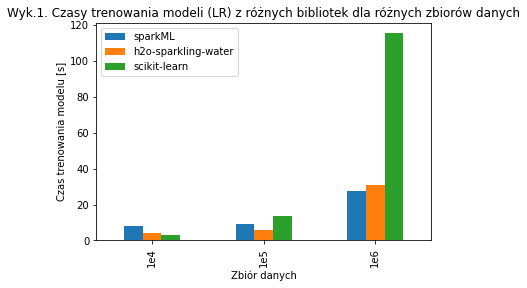

In [25]:
lr_basic_models_training_times_data = [
    [sparkML_lr_basic_1e4_results.training_time, h2o_lr_basic_1e4_results.training_time, sklearn_lr_basic_1e4_results.training_time],
    [sparkML_lr_basic_1e5_results.training_time, h2o_lr_basic_1e5_results.training_time, sklearn_lr_basic_1e5_results.training_time],
    [sparkML_lr_basic_1e6_results.training_time, h2o_lr_basic_1e6_results.training_time, sklearn_lr_basic_1e6_results.training_time],
]

lr_basic_models_training_times_df = pd.DataFrame(lr_basic_models_training_times_data, columns=['sparkML', 'h2o-sparkling-water', 'scikit-learn'], index=['1e4', '1e5', '1e6'])

lr_basic_models_training_times_df.plot.bar()
plt.title('Wyk.1. Czasy trenowania modeli (LR) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

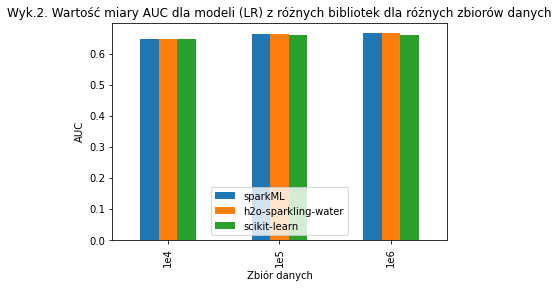

In [26]:
lr_basic_models_auc_data = [
    [sparkML_lr_basic_1e4_results.auc, h2o_lr_basic_1e4_results.auc, sklearn_lr_basic_1e4_results.auc],
    [sparkML_lr_basic_1e5_results.auc, h2o_lr_basic_1e5_results.auc, sklearn_lr_basic_1e5_results.auc],
    [sparkML_lr_basic_1e6_results.auc, h2o_lr_basic_1e6_results.auc, sklearn_lr_basic_1e6_results.auc],
]

lr_basic_models_auc_df = pd.DataFrame(lr_basic_models_auc_data, columns=['sparkML', 'h2o-sparkling-water', 'scikit-learn'], index=['1e4', '1e5', '1e6'])

lr_basic_models_auc_df.plot.bar()
plt.title('Wyk.2. Wartość miary AUC dla modeli (LR) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('AUC')
plt.show()

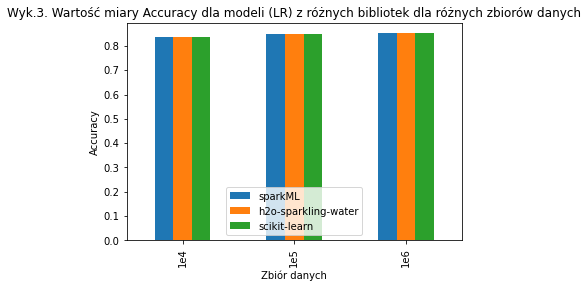

In [27]:
lr_basic_models_accuracy_data = [
    [sparkML_lr_basic_1e4_results.accuracy, h2o_lr_basic_1e4_results.accuracy, sklearn_lr_basic_1e4_results.accuracy],
    [sparkML_lr_basic_1e5_results.accuracy, h2o_lr_basic_1e5_results.accuracy, sklearn_lr_basic_1e5_results.accuracy],
    [sparkML_lr_basic_1e6_results.accuracy, h2o_lr_basic_1e6_results.accuracy, sklearn_lr_basic_1e6_results.accuracy],
]

lr_basic_models_accuracy_df = pd.DataFrame(lr_basic_models_accuracy_data, columns=['sparkML', 'h2o-sparkling-water', 'scikit-learn'], index=['1e4', '1e5', '1e6'])

lr_basic_models_accuracy_df.plot.bar()
plt.title('Wyk.3. Wartość miary Accuracy dla modeli (LR) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Accuracy')
plt.show()

Analizując zgromadzone wyniki możemy zauważyć, że w kwestii jakości predykcji wszystkie badane implementacje są niemal identyczne. Dla poszczególnych rozmiarów zbiorów danych, miary AUC i Accuracy dla bibliotek sparkML oraz h2o-sparkling-water są prawie takie same, jedynie scikit-learn zdaje się oferować minimalne mniejsze wartości miar dla większych zbiorów danych. Dla wszystkich modeli widzimy drobny wzrost wartości AUC i Accuracy wraz ze wzrostem rozmiarów zbiorów danych.

W kwestii czasu trenowania modeli, widzimy że dla najmniejszego zbioru danych 1e4, czas trenowania jest najmniejszy dla nierozproszonej implementacji regresji logistycznej, a najdłuższy dla implementacji z biblioteki sparkML. Jednak dla większych zbiorów danych, implementacja ze scikit-learn radzi sobie coraz gorzej, co najbardziej widać dla zbioru danych 1e6. Może to wynikać m.in. ze sposobu przygotowania danych dla tego modelu - data frame'y dla implementacji rozproszonych są mapowane na odpowiednie data frame'y dla biblioteki scikit-learn. Dla zbioru danych 1e6 możemy też zauważyć, że czas trenowania modelu z implementacji sparkowej prześciga o kilka sekund implementację z h2o-sparkling-water. Biorąc pod uwagę specyfikę środowiska testowego (wirtualna maszyna) można by uznać, że obie implementacje rozproszone mają zbliżony czas trenowania modeli regresji logistycznej.

# **Regresja logistyczna - optymalizacja hiperparametrów modeli na zbiorze danych 1e6**

Dla każdej badanej implementacji modelu typu regresja logistyczna, spróbowaliśmy dokonać optymalizacji ich parametrów. Wyniki dla nowo otrzymanych modeli porównaliśmy z ich wersjami bazowymi. Optymalizację, trenowanie i testowanie modeli przeprowadziliśmy na zbiorze danych 1e6.

Dla każdej biblioteki dokonaliśmy optymalizacji dla różnych parametrów, z wykorzystaniem metod detykowanych dla tych bibliotek. Szczegóły w implementacjach kolejnych wywoływanych funkcji.

## sparkML

In [28]:
sparkML_lr_tuning_1e6_results = tune_and_test_sparkML_lr(training_df_1e6, testing_df_1e6)


label_sparkML_lr_tuning_1e6_results = 'Regresja logistyczna, sparkML, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(sparkML_lr_tuning_1e6_results, label_sparkML_lr_tuning_1e6_results)

----- Regresja logistyczna, sparkML, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    regParam: 0.0
    elasticNetParam: 0.0
AUC: 0.665
Accuracy: 0.852
Macierz pomyłek:
   label  prediction   count
0      0         0.0     130
1      0         1.0   29553
2      1         0.0      90
3      1         1.0  170283


## H2O-sparklinkg-water

In [29]:
h2o_lr_tuning_1e6_results = tune_and_test_h2o_lr(training_df_1e6, testing_df_1e6)


label_h2o_lr_tuning_1e6_results = 'Regresja logistyczna, H2O-sparkling-water, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(h2o_lr_tuning_1e6_results, label_h2o_lr_tuning_1e6_results)

----- Regresja logistyczna, H2O-sparkling-water, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    alphaValue: 0.0
    lambdaValue: 0.0
AUC: 0.665
Accuracy: 0.852
Macierz pomyłek:
   label prediction   count
0      0          0      33
1      0          1   29650
2      1          0      21
3      1          1  170352


## scikit-learn

In [30]:
sklearn_lr_tuning_1e6_results = tune_and_test_sklearn_lr(training_df_1e6, testing_df_1e6)
# sklearn_lr_tuning_1e6_results = ModelTuningResults()

label_sklearn_lr_tuning_1e6_results = 'Regresja logistyczna, scikit-learn, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(sklearn_lr_tuning_1e6_results, label_sklearn_lr_tuning_1e6_results)

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'libline

----- Regresja logistyczna, scikit-learn, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    C: 1.0
    penalty: l2
    solver: liblinear
AUC: 0.665
Accuracy: 0.852
Macierz pomyłek:
   label  prediction   count
0      0           0     130
1      0           1   29553
2      1           0      91
3      1           1  170282


## Analiza wyników

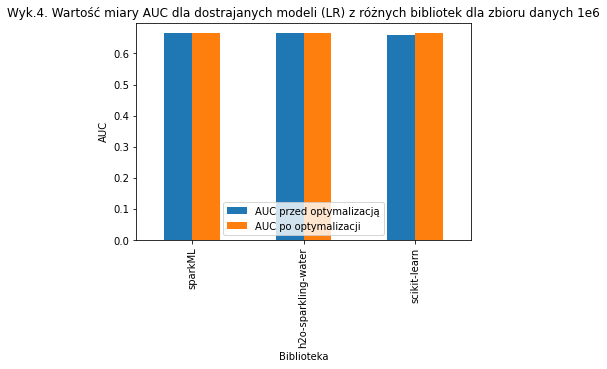

In [31]:
lr_tuned_models_auc_data = [
    [sparkML_lr_basic_1e6_results.auc, sparkML_lr_tuning_1e6_results.auc],
    [h2o_lr_basic_1e6_results.auc, h2o_lr_tuning_1e6_results.auc],
    [sklearn_lr_basic_1e6_results.auc, sklearn_lr_tuning_1e6_results.auc]
]

lr_tuned_models_auc_df = pd.DataFrame(lr_tuned_models_auc_data, columns=['AUC przed optymalizacją', 'AUC po optymalizacji'], index=['sparkML', 'h2o-sparkling-water', 'scikit-learn'])

lr_tuned_models_auc_df.plot.bar()
plt.title('Wyk.4. Wartość miary AUC dla dostrajanych modeli (LR) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('AUC')
plt.show()

In [32]:
lr_tuned_models_auc_df

,AUC przed optymalizacją,AUC po optymalizacji
sparkML,0.664876,0.664874
h2o-sparkling-water,0.664882,0.664872
scikit-learn,0.660399,0.664850


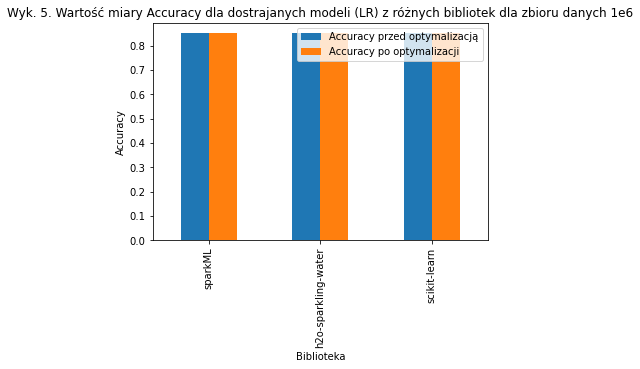

In [33]:
lr_tuned_models_accuracy_data = [
    [sparkML_lr_basic_1e6_results.accuracy, sparkML_lr_tuning_1e6_results.accuracy],
    [h2o_lr_basic_1e6_results.accuracy, h2o_lr_tuning_1e6_results.accuracy],
    [sklearn_lr_basic_1e6_results.accuracy, sklearn_lr_tuning_1e6_results.accuracy]
]

lr_tuned_models_accuracy_df = pd.DataFrame(lr_tuned_models_accuracy_data, columns=['Accuracy przed optymalizacją', 'Accuracy po optymalizacji'], index=['sparkML', 'h2o-sparkling-water', 'scikit-learn'])

lr_tuned_models_accuracy_df.plot.bar()
plt.title('Wyk. 5. Wartość miary Accuracy dla dostrajanych modeli (LR) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('Accuracy')
plt.show()

In [34]:
lr_tuned_models_accuracy_df

,Accuracy przed optymalizacją,Accuracy po optymalizacji
sparkML,0.851826,0.851826
h2o-sparkling-water,0.851642,0.851687
scikit-learn,0.851722,0.851821


Dokonane przez nas próby optymalizacji modelów nie przyniosły znaczącej poprawy w jakości predykcji modeli. Jedynie dla implementacji z bibliotek scikit-learn można zauważyć minimalną poprawę wartości AUC i Accuracy.

# **Regresja logistyczna - porównanie czasu trenowania modeli dla zbioru danych 1e6 w zależności od liczby dostępnych wątków**

Dla różnej liczby dostępnych wątków w środowisku testowym (1, 2 i 3), sprawdziliśmy czasy trenowania bazowych wersji modeli typu regresja logistyczna z bibliotek Spark, h2o-sparkling-water oraz scikit-learn. W niniejszym sprawozdaniu przedstawiliśmy wyniki dla zbioru danych 1e6

**Ze względu na problemy z resetowaniem kontekstu h2o w ramach jednego notatnika (co było konieczne do zmiany liczby dostępnych wątków), eksperymenty dla tego zadania przeprowadziliśmy w oddzielnych notatnikach, a ich wyniki przepisaliśmy do niniejszego sprawozdania. Notatniki można znaleźć w folderze tbd-notebooks/cores_testing.**

In [35]:
lr_basic_models_training_times_for_cores_data = [
    [57.245, 34.946, 25.672],
    [58.314, 38.361, 27.613],
    [119.977, 306.877, 304.123]
]

## Analiza wyników

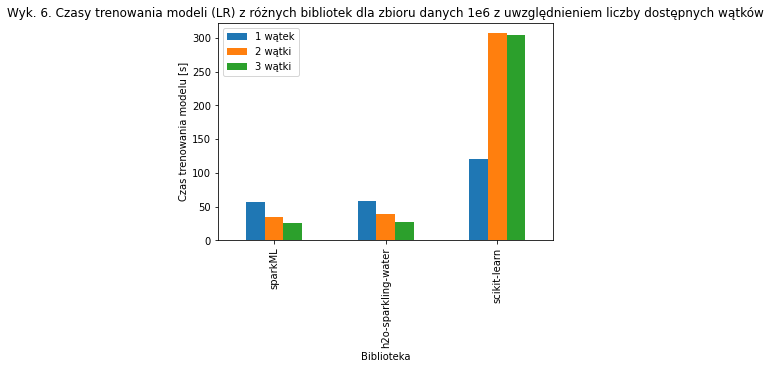

In [36]:
lr_basic_models_training_times_for_cores_df = pd.DataFrame(lr_basic_models_training_times_for_cores_data, columns=['1 wątek', '2 wątki', '3 wątki'], index=['sparkML', 'h2o-sparkling-water', 'scikit-learn'])

lr_basic_models_training_times_for_cores_df.plot.bar()
plt.title('Wyk. 6. Czasy trenowania modeli (LR) z różnych bibliotek dla zbioru danych 1e6 z uwzględnieniem liczby dostępnych wątków')
plt.xlabel('Biblioteka')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

In [37]:
lr_basic_models_training_times_for_cores_df

,1 wątek,2 wątki,3 wątki
sparkML,57.245,34.946,25.672
h2o-sparkling-water,58.314,38.361,27.613
scikit-learn,119.977,306.877,304.123


Zarówno dla implementacji regresji logistycznej ze sparkML jak i h2o-sparkling-water, możemy obserwować podobne spadki w czasie trenowania modeli wraz ze wzrostem liczby dostępnych wątków. Ponownie obserwujemy, że czasy trenowania modeli dla tych bibliotek są w gruncie rzeczy zbliżone. Jedynie dla implementacji nierozproszonej (scikit-learn) obserwujemy dziwne zachowanie dla liczby wątków większej niż 1. Ustawienie parametru n_jobs na wartość większą od 1 spowodowało znaczny wzrost czasu trenowania modelu dla biblioteki scikit-learn, przy czym dla 2 i 3 wątków czasy są podobne.

# **Gradient Boosted Trees - porównanie wyników klasyfikacji oraz czasu trenowania podstawowych wersji modeli dla różnych wielkości zbiorów danych**

Dla każdego otrzymanego zbioru danych, przeprowadziliśmy trenowanie podstawowych wersji (z domyślnymi parametrami) modeli typu Gradient Boosted Trees. Ich implementacje zaczerpnęliśmy z trzech bibliotek: Spark, h2o-sparkling-water oraz SynapseML. Podczas trenowania mierzyliśmy jego czas, a następnie dla otrzymanych modeli sprawdziliśmy na zbiorze testowym wartości AUC, Accuracy oraz macierz pomyłek.

## Zbiór danych 1e4

In [38]:
sparkML_gbt_basic_1e4_results = test_sparkML_gbt_basic_version(training_df_1e4, testing_df_1e4)

label_sparkML_gbt_basic_1e4_results = 'Gradient Boosted Trees, sparkML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_gbt_basic_1e4_results, label_sparkML_gbt_basic_1e4_results)

----- Gradient Boosted Trees, sparkML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 9.976s
AUC: 0.675
Accuracy: 0.837
Macierz pomyłek:
   label  prediction  count
0      0         0.0      3
1      0         1.0    325
2      1         0.0      7
3      1         1.0   1698


In [39]:
h2o_gbt_basic_1e4_results = test_h2o_gbt_basic_version(training_df_1e4, testing_df_1e4)

label_h2o_gbt_basic_1e4_results = 'Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_gbt_basic_1e4_results, label_h2o_gbt_basic_1e4_results)

----- Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 4.985s
AUC: 0.655
Accuracy: 0.815
Macierz pomyłek:
   label prediction  count
0      0          0     56
1      0          1    272
2      1          0    104
3      1          1   1601


In [40]:
synapseML_gbt_basic_1e4_results = test_synapseML_gbt_basic_version(training_df_1e4, testing_df_1e4)

label_synapseML_gbt_basic_1e4_results = 'Gradient Boosted Trees, SynapseML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(synapseML_gbt_basic_1e4_results, label_synapseML_gbt_basic_1e4_results)

----- Gradient Boosted Trees, SynapseML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 2.068s
AUC: 0.676
Accuracy: 0.838
Macierz pomyłek:
   label  prediction  count
0      0         0.0      9
1      0         1.0    319
2      1         0.0     10
3      1         1.0   1695


## Zbiór danych 1e5

In [41]:
sparkML_gbt_basic_1e5_results = test_sparkML_gbt_basic_version(training_df_1e5, testing_df_1e5)

label_sparkML_gbt_basic_1e5_results = 'Gradient Boosted Trees, sparkML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_gbt_basic_1e5_results, label_sparkML_gbt_basic_1e5_results)

----- Gradient Boosted Trees, sparkML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 18.125s
AUC: 0.677
Accuracy: 0.848
Macierz pomyłek:
   label  prediction  count
0      0         0.0      9
1      0         1.0   3000
2      1         0.0     14
3      1         1.0  16869


In [42]:
h2o_gbt_basic_1e5_results = test_h2o_gbt_basic_version(training_df_1e5, testing_df_1e5)

label_h2o_gbt_basic_1e5_results = 'Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_gbt_basic_1e5_results, label_h2o_gbt_basic_1e5_results)

----- Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 9.47s
AUC: 0.682
Accuracy: 0.847
Macierz pomyłek:
   label prediction  count
0      0          0    127
1      0          1   2882
2      1          0    164
3      1          1  16719


In [43]:
synapseML_gbt_basic_1e5_results = test_synapseML_gbt_basic_version(training_df_1e5, testing_df_1e5)

label_synapseML_gbt_basic_1e5_results = 'Gradient Boosted Trees, SynapseML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(synapseML_gbt_basic_1e5_results, label_synapseML_gbt_basic_1e5_results)

----- Gradient Boosted Trees, SynapseML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 6.104s
AUC: 0.685
Accuracy: 0.849
Macierz pomyłek:
   label  prediction  count
0      0         0.0     31
1      0         1.0   2978
2      1         0.0     23
3      1         1.0  16860


## Zbiór danych 1e6

In [44]:
sparkML_gbt_basic_1e6_results = test_sparkML_gbt_basic_version(training_df_1e6, testing_df_1e6)

label_sparkML_gbt_basic_1e6_results = 'Gradient Boosted Trees, sparkML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_gbt_basic_1e6_results, label_sparkML_gbt_basic_1e6_results)

----- Gradient Boosted Trees, sparkML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 169.134s
AUC: 0.679
Accuracy: 0.852
Macierz pomyłek:
   label  prediction   count
0      0         0.0     120
1      0         1.0   29563
2      1         0.0      77
3      1         1.0  170296


In [45]:
h2o_gbt_basic_1e6_results = test_h2o_gbt_basic_version(training_df_1e6, testing_df_1e6)

label_h2o_gbt_basic_1e6_results = 'Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_gbt_basic_1e6_results, label_h2o_gbt_basic_1e6_results)

----- Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 57.398s
AUC: 0.694
Accuracy: 0.852
Macierz pomyłek:
   label prediction   count
0      0          0     479
1      0          1   29204
2      1          0     335
3      1          1  170038


In [46]:
synapseML_gbt_basic_1e6_results = test_synapseML_gbt_basic_version(training_df_1e6, testing_df_1e6)

label_synapseML_gbt_basic_1e6_results = 'Gradient Boosted Trees, SynapseML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(synapseML_gbt_basic_1e6_results, label_synapseML_gbt_basic_1e6_results)

----- Gradient Boosted Trees, SynapseML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 30.953s
AUC: 0.694
Accuracy: 0.852
Macierz pomyłek:
   label  prediction   count
0      0         0.0     397
1      0         1.0   29286
2      1         0.0     276
3      1         1.0  170097


## Analiza wyników

In [47]:
models_gbt_basic_scores_data = [
    ['1e4', 'sparkML', sparkML_gbt_basic_1e4_results.training_time, sparkML_gbt_basic_1e4_results.auc, sparkML_gbt_basic_1e4_results.accuracy],
    ['1e4', 'h2o-sparkling-water', h2o_gbt_basic_1e4_results.training_time, h2o_gbt_basic_1e4_results.auc, h2o_lr_basic_1e4_results.accuracy],
    ['1e4', 'synapseML', synapseML_gbt_basic_1e4_results.training_time, synapseML_gbt_basic_1e4_results.auc, synapseML_gbt_basic_1e4_results.accuracy],
    ['1e5', 'sparkML', sparkML_gbt_basic_1e5_results.training_time, sparkML_gbt_basic_1e5_results.auc, sparkML_gbt_basic_1e5_results.accuracy],
    ['1e5', 'h2o-sparkling-water', h2o_gbt_basic_1e5_results.training_time, h2o_gbt_basic_1e5_results.auc, h2o_gbt_basic_1e5_results.accuracy],
    ['1e5', 'ssynapseML', synapseML_gbt_basic_1e5_results.training_time, synapseML_gbt_basic_1e5_results.auc, synapseML_gbt_basic_1e5_results.accuracy],
    ['1e6', 'sparkML', sparkML_gbt_basic_1e6_results.training_time, sparkML_gbt_basic_1e6_results.auc, sparkML_gbt_basic_1e6_results.accuracy],
    ['1e6', 'h2o-sparkling-water', h2o_gbt_basic_1e6_results.training_time, h2o_gbt_basic_1e6_results.auc, h2o_gbt_basic_1e6_results.accuracy],
    ['1e6', 'synapseML', synapseML_gbt_basic_1e6_results.training_time, synapseML_gbt_basic_1e6_results.auc, synapseML_gbt_basic_1e6_results.accuracy],
]

models_gbt_basic_scores_df = pd.DataFrame(models_gbt_basic_scores_data, columns=['Zbiór danych', 'Biblioteka', 'Czas trenowania (s)', 'AUC', 'Accuracy'])
models_gbt_basic_scores_df

,Zbiór danych,Biblioteka,Czas trenowania (s),AUC,Accuracy
0,1e4,sparkML,9.976248,0.674647,0.836695
1,1e4,h2o-sparkling-water,4.985150,0.654710,0.836695
2,1e4,synapseML,2.068002,0.675641,0.838170
3,1e5,sparkML,18.125042,0.677357,0.848482
4,1e5,h2o-sparkling-water,9.470126,0.682118,0.846873
5,1e5,ssynapseML,6.104023,0.684524,0.849135
6,1e6,sparkML,169.134417,0.678848,0.851841
7,1e6,h2o-sparkling-water,57.398005,0.693875,0.852346
8,1e6,synapseML,30.952891,0.694211,0.852231


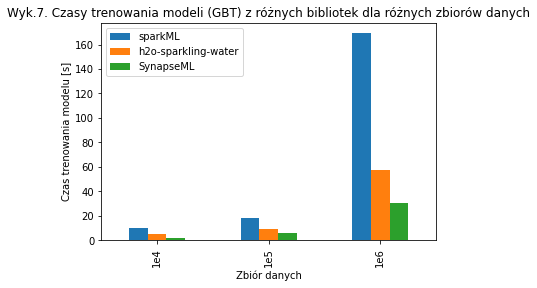

In [48]:
gbt_basic_models_training_times_data = [
    [sparkML_gbt_basic_1e4_results.training_time, h2o_gbt_basic_1e4_results.training_time, synapseML_gbt_basic_1e4_results.training_time],
    [sparkML_gbt_basic_1e5_results.training_time, h2o_gbt_basic_1e5_results.training_time, synapseML_gbt_basic_1e5_results.training_time],
    [sparkML_gbt_basic_1e6_results.training_time, h2o_gbt_basic_1e6_results.training_time, synapseML_gbt_basic_1e6_results.training_time],
]

gbt_basic_models_training_times_df = pd.DataFrame(gbt_basic_models_training_times_data, columns=['sparkML', 'h2o-sparkling-water', 'SynapseML'], index=['1e4', '1e5', '1e6'])

gbt_basic_models_training_times_df.plot.bar()
plt.title('Wyk.7. Czasy trenowania modeli (GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

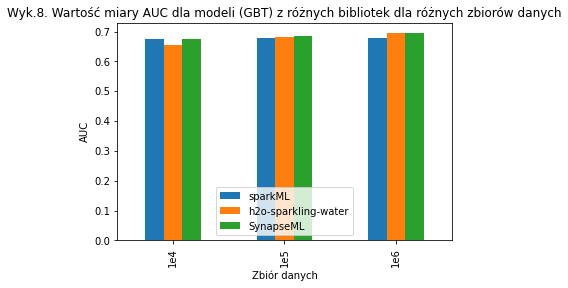

In [49]:
gbt_basic_models_auc_data = [
    [sparkML_gbt_basic_1e4_results.auc, h2o_gbt_basic_1e4_results.auc, synapseML_gbt_basic_1e4_results.auc],
    [sparkML_gbt_basic_1e5_results.auc, h2o_gbt_basic_1e5_results.auc, synapseML_gbt_basic_1e5_results.auc],
    [sparkML_gbt_basic_1e6_results.auc, h2o_gbt_basic_1e6_results.auc, synapseML_gbt_basic_1e6_results.auc],
]

gbt_basic_models_auc_df = pd.DataFrame(gbt_basic_models_auc_data, columns=['sparkML', 'h2o-sparkling-water', 'SynapseML'], index=['1e4', '1e5', '1e6'])

gbt_basic_models_auc_df.plot.bar()
plt.title('Wyk.8. Wartość miary AUC dla modeli (GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('AUC')
plt.show()

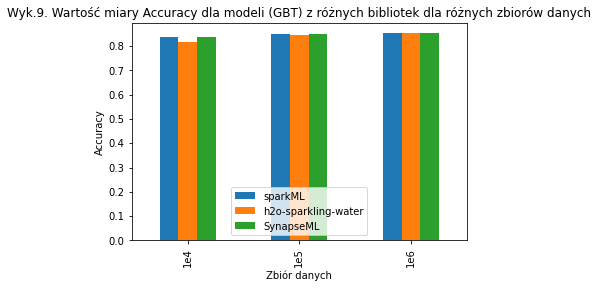

In [50]:
gbt_basic_models_accuracy_data = [
    [sparkML_gbt_basic_1e4_results.accuracy, h2o_gbt_basic_1e4_results.accuracy, synapseML_gbt_basic_1e4_results.accuracy],
    [sparkML_gbt_basic_1e5_results.accuracy, h2o_gbt_basic_1e5_results.accuracy, synapseML_gbt_basic_1e5_results.accuracy],
    [sparkML_gbt_basic_1e6_results.accuracy, h2o_gbt_basic_1e6_results.accuracy, synapseML_gbt_basic_1e6_results.accuracy],
]

gbt_basic_models_accuracy_df = pd.DataFrame(gbt_basic_models_accuracy_data, columns=['sparkML', 'h2o-sparkling-water', 'SynapseML'], index=['1e4', '1e5', '1e6'])

gbt_basic_models_accuracy_df.plot.bar()
plt.title('Wyk.9. Wartość miary Accuracy dla modeli (GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Accuracy')
plt.show()

W kwestii jakości predykcji dla różnych implementacji modeli GBT, widzimy nieco większą różnorodność wyników niż w przypadku regresji logistycznej. Ponownie możemy zaobserwować, że wraz ze wzrostem rozmiarów zbiorów danych, modele uzyskują lepsze wyniki predykcji (nieznacznie). Implementacja z biblioteki h2o-sparkling-water uzyskuje najmniejsze wartości miar AUC i Accuracy dla zbioru 1e4, jednak dla pozostałych zbiorów  zdaje się uzyskiwać niemal identyczne wyniki co synapseML. Wartość AUC dla biblioteki sparkML ustępuje pozostałym modelom wraz ze zwiększaniem zbioru danych. Dla wszystkich miar i dla wszystkich zbiorów danych, SynapseML zdaje się osiągać najlepsze rezultaty.

Przewaga SynapseMl uwidacznia się jeszcze bardziej przy badaniu czasu trenowania modeli. Dla każdego zbioru danych, synapseML jest kilkukrotnie szybszy od najwolniejszej w zestawieniu implementacji z biblioteki sparkML. Na wykresie 7. łatwo zauważyć, że dla każdej biblioteki czas trenowania rośnie wraz ze wzrostem rozmiarów zbiorów danych

# **Gradient Boosted Trees - optymalizacja hiperparametrów modeli na zbiorze danych 1e6**

Dla każdej badanej implementacji modelu typu Gradient Boosted Trees, spróbowaliśmy dokonać optymalizacji ich parametrów. Wyniki dla nowo otrzymanych modeli porównaliśmy z ich wersjami bazowymi. Optymalizację, trenowanie i testowanie modeli przeprowadziliśmy na zbiorze danych 1e6.

Dla każdej biblioteki dokonaliśmy optymalizacji dla różnych parametrów, z wykorzystaniem metod detykowanych dla tych bibliotek. Szczegóły w implementacjach kolejnych wywoływanych funkcji.

## sparkML

In [51]:
sparkML_gbt_tuning_1e6_results = tune_and_test_sparkML_gbt(training_df_1e6, testing_df_1e6)

label_sparkML_gbt_tuning_1e6_results = 'Gradient Boosted Trees, sparkML, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(sparkML_gbt_tuning_1e6_results, label_sparkML_gbt_tuning_1e6_results)

----- Gradient Boosted Trees, sparkML, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    maxDepth: 10
    maxBins: 64
AUC: 0.687
Accuracy: 0.851
Macierz pomyłek:
   label  prediction   count
0      0         0.0     590
1      0         1.0   29093
2      1         0.0     618
3      1         1.0  169755


## H2O-sparklinkg-water

In [52]:
h2o_gbt_tuning_1e6_results = tune_and_test_h2o_gbt(training_df_1e6, testing_df_1e6)

label_h2o_gbt_tuning_1e6_results = 'Gradient Boosted Trees, H2O-sparklinkg-water, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(h2o_gbt_tuning_1e6_results, label_h2o_gbt_tuning_1e6_results)

----- Gradient Boosted Trees, H2O-sparklinkg-water, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    learnRate: 0.4
    maxDepth: 64
AUC: 0.655
Accuracy: 0.833
Macierz pomyłek:
   label prediction   count
0      0          0    4198
1      0          1   25485
2      1          0    7936
3      1          1  162437


## SynapseML

In [53]:
synapseML_gbt_tuning_1e6_results = tune_and_test_synapseML_gbt(training_df_1e6, testing_df_1e6)

label_synapseML_gbt_tuning_1e6_results = 'Gradient Boosted Trees, SynapseML, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(synapseML_gbt_tuning_1e6_results, label_synapseML_gbt_tuning_1e6_results)

----- Gradient Boosted Trees, SynapseML, zbiór 1e6, optymalizowane hiperparametry -----
AUC: 0.691
Accuracy: 0.852
Macierz pomyłek:
   label  prediction   count
0      0         0.0     286
1      0         1.0   29397
2      1         0.0     184
3      1         1.0  170189


## Analiza wyników

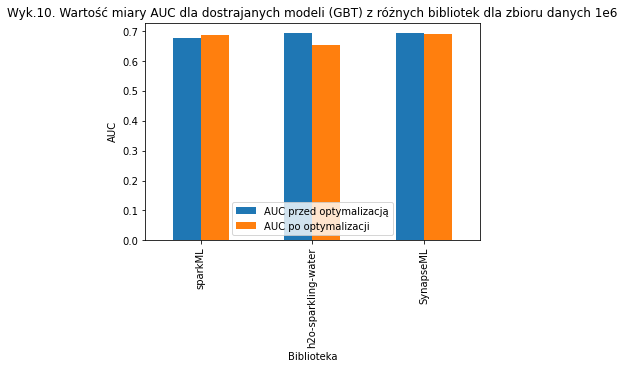

In [54]:
gbt_tuned_models_auc_data = [
    [sparkML_gbt_basic_1e6_results.auc, sparkML_gbt_tuning_1e6_results.auc],
    [h2o_gbt_basic_1e6_results.auc, h2o_gbt_tuning_1e6_results.auc],
    [synapseML_gbt_basic_1e6_results.auc, synapseML_gbt_tuning_1e6_results.auc]
]

gbt_tuned_models_auc_df = pd.DataFrame(gbt_tuned_models_auc_data, columns=['AUC przed optymalizacją', 'AUC po optymalizacji'], index=['sparkML', 'h2o-sparkling-water', 'SynapseML'])

gbt_tuned_models_auc_df.plot.bar()
plt.title('Wyk.10. Wartość miary AUC dla dostrajanych modeli (GBT) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('AUC')
plt.show()

In [55]:
gbt_tuned_models_auc_df

,AUC przed optymalizacją,AUC po optymalizacji
sparkML,0.678848,0.687332
h2o-sparkling-water,0.693875,0.655064
SynapseML,0.694211,0.690920


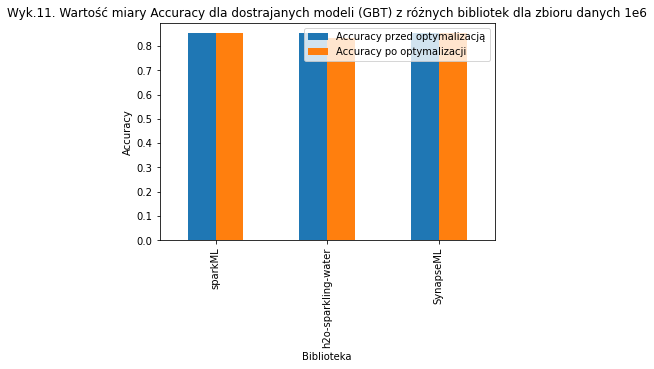

In [56]:
gbt_tuned_models_accuracy_data = [
    [sparkML_gbt_basic_1e6_results.accuracy, sparkML_gbt_tuning_1e6_results.accuracy],
    [h2o_gbt_basic_1e6_results.accuracy, h2o_gbt_tuning_1e6_results.accuracy],
    [synapseML_gbt_basic_1e6_results.accuracy, synapseML_gbt_tuning_1e6_results.accuracy]
]

gbt_tuned_models_accuracy_df = pd.DataFrame(gbt_tuned_models_accuracy_data, columns=['Accuracy przed optymalizacją', 'Accuracy po optymalizacji'], index=['sparkML', 'h2o-sparkling-water', 'SynapseML'])

gbt_tuned_models_accuracy_df.plot.bar()
plt.title('Wyk.11. Wartość miary Accuracy dla dostrajanych modeli (GBT) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('Accuracy')
plt.show()

In [57]:
gbt_tuned_models_accuracy_df

,Accuracy przed optymalizacją,Accuracy po optymalizacji
sparkML,0.851841,0.851487
h2o-sparkling-water,0.852346,0.832942
SynapseML,0.852231,0.852136


Dla implementacji z biblioteki sparkML udało nam się minimalnie poprawić jakość predykcji modelu, jednak wciąż nie jest ona lepsza niż dla niezoptymalizowanego modelu z biblioteki SynapseML.

# **Gradient Boosted Trees - porównanie czasu trenowania modeli dla zbioru danych 1e6 w zależności od liczby dostępnych wątków**

Dla różnej liczby dostępnych wątków w środowisku testowym (1, 2 i 3), sprawdziliśmy czasy trenowania bazowych wersji modelów typu Gradient Boosted Trees z bibliotek Spark, h2o-sparkling-water oraz SynapseML. W niniejszym sprawozdaniu przedstawiliśmy wyniki dla zbioru danych 1e6

**Ze względu na problemy z resetowaniem kontekstu h2o w ramach jednego notatnika (co było konieczne do zmiany liczby dostępnych wątków), eksperymenty dla tego zadania przeprowadziliśmy w oddzielnych notatnikach, a ich wyniki przepisaliśmy do niniejszego sprawozdania. Notatniki można znaleźć w folderze tbd-notebooks/cores_testing.**

In [58]:
gbt_basic_models_training_times_for_cores_data = [
    [299.921, 127.415, 82.888],
    [137.942, 78.894, 60.38],
    [69.243, 39.783, 28.615]
]

## Analiza wyników

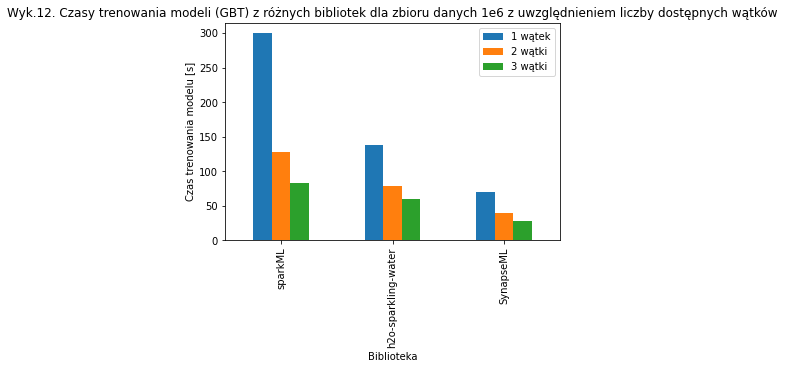

In [59]:
gbt_basic_models_training_times_for_cores_df = pd.DataFrame(gbt_basic_models_training_times_for_cores_data, columns=['1 wątek', '2 wątki', '3 wątki'], index=['sparkML', 'h2o-sparkling-water', 'SynapseML'])

gbt_basic_models_training_times_for_cores_df.plot.bar()
plt.title('Wyk.12. Czasy trenowania modeli (GBT) z różnych bibliotek dla zbioru danych 1e6 z uwzględnieniem liczby dostępnych wątków')
plt.xlabel('Biblioteka')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

In [60]:
gbt_basic_models_training_times_for_cores_df

,1 wątek,2 wątki,3 wątki
sparkML,299.921,127.415,82.888
h2o-sparkling-water,137.942,78.894,60.380
SynapseML,69.243,39.783,28.615


Dla każdej implementacji modelu GBT obserwujemy spadek czasu trenowania modeli wraz ze wzrostem liczby dostępnych wątków. Dla większej liczby wątków maleją też różnice w czasie trenowania między poszczególnymi implementacjami (szczególnie widoczne dla sparkML). Ponownie najkrótsze czasy trenowania modeli są widoczne dla biblioteki SynapseML.

# **Wnioski i podsumowanie**

## Wartość miary AUC dla modeli bazowych

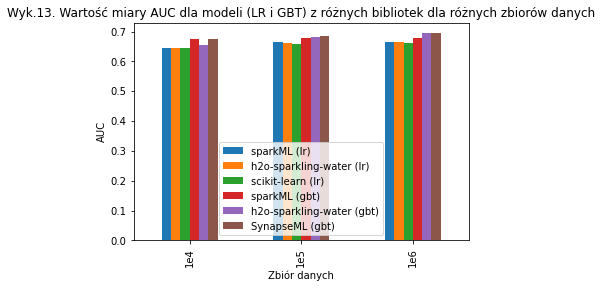

In [61]:
basic_models_auc_data = [
    [sparkML_lr_basic_1e4_results.auc, h2o_lr_basic_1e4_results.auc, sklearn_lr_basic_1e4_results.auc, sparkML_gbt_basic_1e4_results.auc, h2o_gbt_basic_1e4_results.auc, synapseML_gbt_basic_1e4_results.auc],
    [sparkML_lr_basic_1e5_results.auc, h2o_lr_basic_1e5_results.auc, sklearn_lr_basic_1e5_results.auc, sparkML_gbt_basic_1e5_results.auc, h2o_gbt_basic_1e5_results.auc, synapseML_gbt_basic_1e5_results.auc],
    [sparkML_lr_basic_1e6_results.auc, h2o_lr_basic_1e6_results.auc, sklearn_lr_basic_1e6_results.auc, sparkML_gbt_basic_1e6_results.auc, h2o_gbt_basic_1e6_results.auc, synapseML_gbt_basic_1e6_results.auc]
]

basic_models_auc_df = pd.DataFrame(basic_models_auc_data, columns=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'], index=['1e4', '1e5', '1e6'])

basic_models_auc_df.plot.bar()
plt.title('Wyk.13. Wartość miary AUC dla modeli (LR i GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('AUC')
plt.show()

In [62]:
basic_models_auc_df

,sparkML (lr),h2o-sparkling-water (lr),scikit-learn (lr),sparkML (gbt),h2o-sparkling-water (gbt),SynapseML (gbt)
1e4,0.645819,0.645907,0.645725,0.674647,0.654710,0.675641
1e5,0.666214,0.662145,0.658434,0.677357,0.682118,0.684524
1e6,0.664876,0.664882,0.660399,0.678848,0.693875,0.694211


## Wartość miary Accuracy dla modeli bazowych

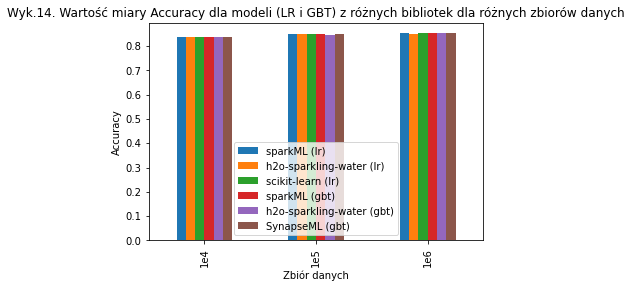

In [63]:
basic_models_accuracy_data = [
    [sparkML_lr_basic_1e4_results.accuracy, h2o_lr_basic_1e4_results.accuracy, sklearn_lr_basic_1e4_results.accuracy, sparkML_gbt_basic_1e4_results.accuracy, h2o_gbt_basic_1e4_results.accuracy, synapseML_gbt_basic_1e4_results.accuracy],
    [sparkML_lr_basic_1e5_results.accuracy, h2o_lr_basic_1e5_results.accuracy, sklearn_lr_basic_1e5_results.accuracy, sparkML_gbt_basic_1e5_results.accuracy, h2o_gbt_basic_1e5_results.accuracy, synapseML_gbt_basic_1e5_results.accuracy],
    [sparkML_lr_basic_1e6_results.accuracy, h2o_lr_basic_1e6_results.accuracy, sklearn_lr_basic_1e6_results.accuracy, sparkML_gbt_basic_1e6_results.accuracy, h2o_gbt_basic_1e6_results.accuracy, synapseML_gbt_basic_1e6_results.accuracy]
]

basic_models_accuracy_df = pd.DataFrame(basic_models_accuracy_data, columns=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'], index=['1e4', '1e5', '1e6'])

basic_models_accuracy_df.plot.bar()
plt.title('Wyk.14. Wartość miary Accuracy dla modeli (LR i GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Accuracy')
plt.show()

In [64]:
basic_models_accuracy_df

,sparkML (lr),h2o-sparkling-water (lr),scikit-learn (lr),sparkML (gbt),h2o-sparkling-water (gbt),SynapseML (gbt)
1e4,0.836203,0.836695,0.838662,0.836695,0.836695,0.838170
1e5,0.848633,0.848482,0.848733,0.848482,0.846873,0.849135
1e6,0.851826,0.851642,0.851722,0.851841,0.852346,0.852231


## Wartość miary AUC dla modeli optymalizowanych

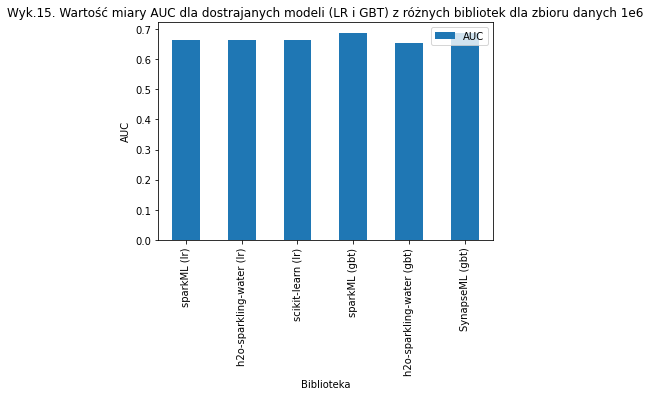

In [65]:
tuned_models_auc_data = [
    [sparkML_lr_tuning_1e6_results.auc],
    [h2o_lr_tuning_1e6_results.auc],
    [sklearn_lr_tuning_1e6_results.auc],
    [sparkML_gbt_tuning_1e6_results.auc],
    [h2o_gbt_tuning_1e6_results.auc],
    [sparkML_gbt_tuning_1e6_results.auc]
]

tuned_models_auc_df = pd.DataFrame(tuned_models_auc_data, columns=['AUC'], index=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'])

tuned_models_auc_df.plot.bar()
plt.title('Wyk.15. Wartość miary AUC dla dostrajanych modeli (LR i GBT) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('AUC')
plt.show()

In [66]:
tuned_models_auc_df

,AUC
sparkML (lr),0.664874
h2o-sparkling-water (lr),0.664872
scikit-learn (lr),0.664850
sparkML (gbt),0.687332
h2o-sparkling-water (gbt),0.655064
SynapseML (gbt),0.687332


## Wartość miary Accuracy dla modeli optymalizowanych

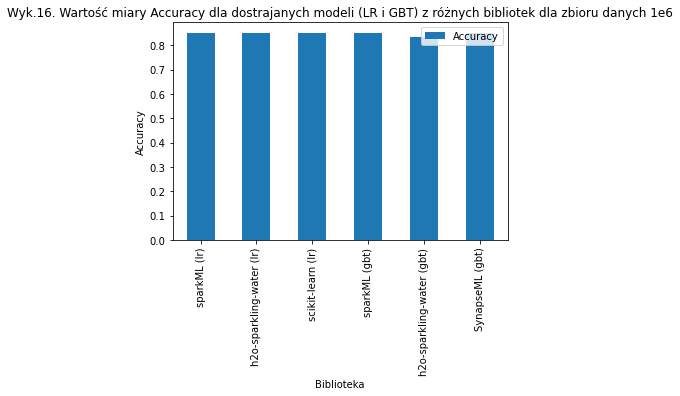

In [67]:
tuned_models_accuracy_data = [
    [sparkML_lr_tuning_1e6_results.accuracy],
    [h2o_lr_tuning_1e6_results.accuracy],
    [sklearn_lr_tuning_1e6_results.accuracy],
    [sparkML_gbt_tuning_1e6_results.accuracy],
    [h2o_gbt_tuning_1e6_results.accuracy],
    [sparkML_gbt_tuning_1e6_results.accuracy]
]

tuned_models_accuracy_df = pd.DataFrame(tuned_models_accuracy_data, columns=['Accuracy'], index=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'])

tuned_models_accuracy_df.plot.bar()
plt.title('Wyk.16. Wartość miary Accuracy dla dostrajanych modeli (LR i GBT) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('Accuracy')
plt.show()

In [68]:
tuned_models_accuracy_df

,Accuracy
sparkML (lr),0.851826
h2o-sparkling-water (lr),0.851687
scikit-learn (lr),0.851821
sparkML (gbt),0.851487
h2o-sparkling-water (gbt),0.832942
SynapseML (gbt),0.851487


## Trenowanie dla różnej liczby rdzeni

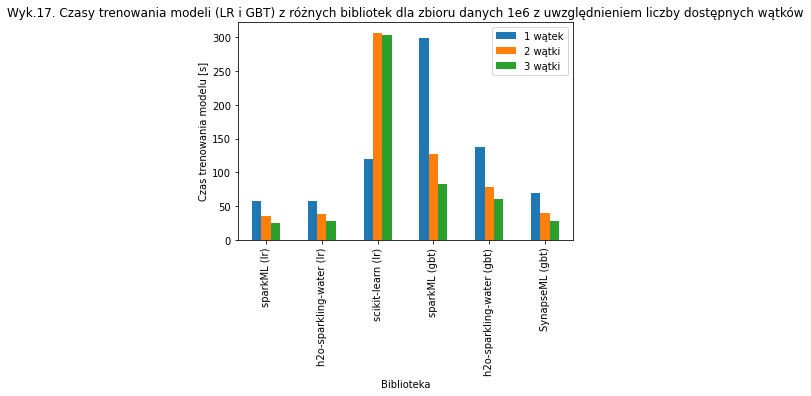

In [69]:
basic_models_training_times_for_cores_data = [
    [57.245, 34.946, 25.672],
    [58.314, 38.361, 27.613],
    [119.977, 306.877, 304.123],
    [299.921, 127.415, 82.888],
    [137.942, 78.894, 60.38],
    [69.243, 39.783, 28.615]
]

basic_models_training_times_for_cores_df = pd.DataFrame(basic_models_training_times_for_cores_data, columns=['1 wątek', '2 wątki', '3 wątki'], index=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'])

basic_models_training_times_for_cores_df.plot.bar()
plt.title('Wyk.17. Czasy trenowania modeli (LR i GBT) z różnych bibliotek dla zbioru danych 1e6 z uwzględnieniem liczby dostępnych wątków')
plt.xlabel('Biblioteka')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

In [70]:
basic_models_training_times_for_cores_df

,1 wątek,2 wątki,3 wątki
sparkML (lr),57.245,34.946,25.672
h2o-sparkling-water (lr),58.314,38.361,27.613
scikit-learn (lr),119.977,306.877,304.123
sparkML (gbt),299.921,127.415,82.888
h2o-sparkling-water (gbt),137.942,78.894,60.380
SynapseML (gbt),69.243,39.783,28.615


Z analizy wszystkich zebranych w niniejszym sprawozdaniu wyników eksperymentów można stwierdzić, że najlepsze rezultaty, zarówno pod względem czasu trenowania jak i jakości predykcji osiąga implementacja GBT z biblioteki SynapseML. Czasy trenowania dla niej są na poziomie czasów trenowania dla mniej wymagających modeli typu LR i znacznie odbiegają od pozostałych implementacji GBT. Na zwiększaniu liczby dostępnych wątków najbardziej zdaje się korzystać implementacja GBT z biblioteki sparkML, jednak dla każdego rozproszonego modelu widać wyraźne skrócenie czasów trenowania.

Lepsze wartości miary AUC osiągają modele typu Gradient Boosted Trees. Wartości Accuracy są bardziej zbliżone między różnymi rodzajami modeli, jednak ta miara jest mniej odporna na nieproporcjonalność zbiorów danych. Generalnie dla większych zbiorów danych wytrenowane modele osiągały lepszą jakość predykcji, jednak sam czas trenowania wzrastał znacząco. Oczywiście oprócz ilości danych ważna też jest ich jakość.

W kwestii strojenia modeli, implementacje Gradient Boosted Trees zdają się pozwalać na bardziej zaawansowaną optymalizację niż modele regresji logistycznej. Każda biblioteka oferuje różne parametry modeli oraz klasy służące do poszukiwania najlepszego zestawu parametrów modeli. Optymalizacja modeli może być czasochłonna i zasobożerna, a i tak uzyskanie lepszych wyników nie jest gwarantowane.

Jeśli chodzi o przygotowanie danych na potrzeby trenowania modeli, to wszystkie testowane implementacje rozproszone korzystały z tych samych struktur danych, o tym samym schemacie i wartościach. Jedyny problem dotyczył biblioteki SynapseML - na jej potrzeby musieliśmy dodatkowo dokonać modyfikacji wartości w kolumnie Light_Conditions tak, aby nie zawierały one znaku ':', który powodował błąd przy próbie trenowania modelu GBT z tej biblioteki. Dla biblioteki scikit-learn musieliśmy dokonać dodatkowego przetworzenia kolumny features i zmiany struktury danych. Oddzielny potok przetwarzania dla tej biblioteki biblioteki mógłby prawdopodobnie poprawić jej czasy trenowania modeli. Zbliżone wartości miar AUC i Accuracy dla poszczególnych rodzajów modeli mogą wskazywać, że użycie jednakowych cech dla różnych implementacji może być wystarczające, jednak aby to potwierdzić należałoby przeprowadzić dodatkowe eksperymenty.

Trzeba też wziąć poprawkę na to, że eksperymenty były przeprowadzane lokalnie na maszynie wirtualnej. Pomiary w środowisku rozproszonym mogłyby pokazać inne wyniki.